In [1]:
#import 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.table import Table
from astropy.io import fits
import numpy.ma as ma
from PIL import Image
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
#custom
import sys 
sys.path.insert(1, 'C:/Users/boibr/OneDrive/Documents/GitHub/MaNGA-VelMap/')
from GenerateCutout import get_cutout,get_cutout_fits
from get_mvel_map import get_mvel_map, calc_chi2


# Data

In [2]:
test_galaxy = '8997-9102'                                           #select test galaxy via plateifu#

data_folder = "/Users/Emlilio/School/Internships/UR ASTRO/Data/"    #choose main folder directory

drpall = data_folder + 'drpall_ttype_R90.fits'                      #open drpall data file in table format
drpalltt = Table.read(drpall, format="fits",hdu=1)                  
drpalltt_dict = {}                   

for i in range(len(drpalltt)):                                      #index in terms of plateifu
    plateifu = drpalltt['plateifu'][i]     
    drpalltt_dict[plateifu] = i 
    
cube_fn = data_folder + 'MaNGA/manga-'+ test_galaxy +'-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'   #set variable for cube file
cube = fits.open(cube_fn)                                           # cube file needs to be opened
stellar_vel = cube['STELLAR_VEL'].data                              #import to variables necessary file information
stellar_mask = cube['STELLAR_VEL_MASK'].data
halpha_vel = cube['EMLINE_GVEL'].data[23]        
halpha_gvel_mask = cube['EMLINE_GVEL_MASK'].data[23]
halpha_gvel_ivar = cube['EMLINE_GVEL_IVAR'].data[23]
ellip_radius = cube['SPX_ELLCOO'].data[3]
spx_x = cube['SPX_SKYCOO'].data[0]
spx_y = cube['SPX_SKYCOO'].data[1]
flux = cube['SPX_MFLUX'].data
cube.close()                                                        #close cube

# Variables

In [3]:
loc = drpalltt_dict[test_galaxy]                                    #loc is the location of the test galaxy within the drpalltt dictionary
mhalpha_vel = ma.array(halpha_vel, mask = halpha_gvel_mask)          #masking the halpha array
mhalpha_ivar = ma.array (halpha_gvel_ivar, mask = halpha_gvel_mask ) #masking the halpha inverse variance data
PA = drpalltt[loc]['nsa_elpetro_phi']                                #PA is the position angle of chosen galaxy
ba = drpalltt[loc]['nsa_elpetro_ba']                                 #ba is the axes ratio of chosen galaxy
z = drpalltt[loc]['z']                                               #z is red-shift value given by sdss 
mask_f = halpha_gvel_mask
x = -spx_x                                                           #x and y are spaxel distance from the center of the galaxy
y = spx_y

alpha = 1.58
Rturn = 0.77*u.kpc
vmax = 222*u.km/u.s
H_0 = 100 *(u.km/u.s)/u.Mpc
q0 = 0.2
c = 299792.458 *(u.km/u.s)
#spax = 1
gal_distance = (c*z)/H_0
gal_dist_kpc = gal_distance.to(u.kpc).value                        #gal_dist_kpc is the distance to the observed galaxy in kpc units
i_angle = np.arccos(np.sqrt(((ba)**2)-(q0**2)/(1-q0**2)))
spax_size = 0.5*(1/60)*(1/60)*(np.pi/180)                          #spax_size is the conversion from spaxels to radians
r_convert = gal_dist_kpc*spax_size                                 #r_convert is the distance of a point from the center of a galaxy in kpc



x_rot = (-x*np.sin(np.radians(PA))+ y*np.cos(np.radians(PA)))/(np.cos(i))        #the following 4 lines get the reoriented coordinates aligned with the galaxy major axis
y_rot = (y*np.sin(np.radians(PA))+x*np.cos(np.radians(PA)))                      
theta = np.arctan(y_rot/x_rot)
rt = (np.sqrt(x_rot**2+y_rot**2)*u.kpc)*np.sign(x_rot)

rot_v = ((vmax*abs(rt))/((((Rturn)**alpha)+(abs(rt)**alpha))**(1/alpha)))*np.sign(x_rot)  #rot_v is the net velocity of a point at a radius from the center

obs_v = ((rot_v*np.sin(i))*np.cos(theta)).value                                           #obs_v is the component of velocity we can observe directly

mobs_v = ma.array(obs_v, mask = stellar_mask)                                             #masks the observed velocity

map_shape = mobs_v.shape                                                                  #map_shape is the shape of the mask observed velocity map

rkpc = gal_dist_kpc*spax_size



# Center Coords

In [4]:
mx = np.max(flux)                              #this function finds the largest flux value in 
indices = np.where(flux == mx)                 #the flux map and appoints it as the center of the galaxy.
mid_pos = [indices[0][0], indices[1][0]]
clean_coords = [int(c) for c in mid_pos]


# Check PA

In [5]:
theta = np.radians(PA-90)                      #theta is PA reoriented to the positive x axis for calculations
for x in range(15,indices[0][0]):       
    y = round(x * np.tan(theta))               #y's are found based on the slope given by PA
    if ma.is_masked(mhalpha_vel[x, y]):
        continue
    else:
                                               #creates the points on the map to be checked for velocity
        v_checkx = 31-x
        v_checky = 31-y
        print(v_checkx,v_checky)
        break

if (mhalpha_vel[v_checkx,v_checky]<0):         # if velocity comes back negative the position angle will be flipped 180 deg, otherwise left alone
    checkedPA = (PA + 180) *(np.pi/180)
else:
    checkedPA = PA*(np.pi/180)
        


15 18


# Call Velocity Function

In [6]:
rturn_kpc = Rturn.value          #rturn_kpc is the unitless version for application in the function

                                                                   
mvel_map = get_mvel_map(map_shape,                       #get_mvel_map is used to get the model vel map
                        vmax, alpha,
                        rturn_kpc,
                        checkedPA,
                        i_angle,
                        clean_coords[0],
                        clean_coords[1],
                        mask_f,r_convert
                       )



In [7]:
if isinstance(r_convert, float):
    print("x is a float")
else:
    print("x is not a float")
print(type(mvel_map))


x is a float
<class 'numpy.ma.MaskedArray'>


# Plot

max = 109.02470076649728min = -109.12619619380254


Text(0.5, 1.0, '8997-9102 Masked H-alpha Velocity')

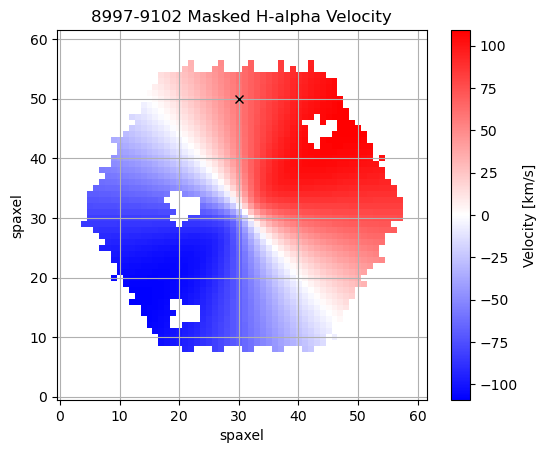

In [14]:
mvel_data = mvel_map.data.value  # Quantity array

mvel_plot = np.ma.array(mvel_data, mask=mask_f) #re-applied mask

val_max = mvel_plot.max()        #simple plotting section for visualization
val_min = mvel_plot.min()
print('max = '+ str(val_max) + 'min = ' + str(val_min))

if (val_max >= abs(val_min)):
    lim = val_max
else:
    lim = abs(val_min)

plt.imshow(mvel_plot,cmap = 'bwr',vmin = -lim, vmax = lim)     #creates a color map of data, (data set, cmap = 'desired color code')
plt.colorbar(label = 'Velocity [km/s]')  #following are just labels
plt.gca().invert_yaxis()
plt.xlabel('spaxel')
plt.ylabel('spaxel')
plt.plot(30,50, marker = 'x', color = 'k')

plt.grid(True)
plt.title(test_galaxy+r' Masked H-alpha Velocity')

In [9]:
params = [vmax, alpha, rturn_kpc, checkedPA, i_angle, clean_coords[0], clean_coords[1]] #create list of parameters to be used for chi2
#calc_chi2(params, mhalpha_vel , mhalpha_ivar, map_shape, r_convert, mask_f )


In [10]:
vmax_guess = 250                               #set up initial guesses to start chi2 minimization
alpha_guess = 1
Rturn_guess = 0.5
PA_guess = checkedPA
i_angle_guess = i_angle
center_guess = clean_coords

x0 = [vmax_guess, alpha_guess, Rturn_guess, PA_guess, i_angle_guess, center_guess[0],center_guess[1]] #make list for guesses to be input as a list

args = (mhalpha_vel, mhalpha_ivar, map_shape, r_convert, mask_f)    #non-variable values to go into minimzation function

vmax_bound = (0, 1000)                                     #setting reasonable bounds for variable used in minimization
alpha_bound = (0.001,100)
Rturn_bound = (0.001,100)
PA_bound = (0,2*np.pi)

i_anglelow = np.max([0,i_angle-np.radians(15)])
i_anglehigh = np.min([np.radians(90), i_angle+np.radians(15)])
i_angle_bound = (i_anglelow, i_anglehigh)

centeri_bound = (center_guess[0]-5,center_guess[0]+5)
centerj_bound = (center_guess[1]-5,center_guess[1]+5)

bounds = np.array([vmax_bound,alpha_bound,Rturn_bound,PA_bound,i_angle_bound,centeri_bound,centerj_bound ]) #make list containing bounds to be sent into minimization function

In [11]:
result = minimize(     #using minimization function on chi2 function
    calc_chi2,
    x0,
    args = args,
    method = 'Powell',
    bounds = bounds,
    options = {'disp': True}    
)

Optimization terminated successfully.
         Current function value: 62022.217684
         Iterations: 9
         Function evaluations: 764


In [12]:
result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 62022.21768435803
       x: [ 2.208e+02  9.066e-01  6.324e-01  5.553e+00  5.729e-01
            2.998e+01  3.056e+01]
     nit: 9
   direc: [[-3.488e-01 -3.029e-02 ...  1.836e-01 -1.584e-01]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 3.494e+00 -2.189e-02 ... -8.697e-02  1.156e-01]]
    nfev: 764

In [13]:
result.x

array([220.82531565,   0.90661865,   0.63239866,   5.55251079,
         0.5729096 ,  29.97778669,  30.56333515])

#fix plotting, and reassign new variable values using result.x index straight in to get_mvel_map function ie. result.x[some num]